Load the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/MyDrive/WebMining2/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 BX-Book-Ratings.csv	    Preprocessed_data.csv
 BX_Books.csv		    PreProcessing.ipynb
 BX-Users.csv		    Prepro_UserItemBased.ipynb
'Copy of WebMining.ipynb'  'RecommenderSystem_on_Steam_data(balanced).ipynb'
 PrePro_Alg.ipynb	    WebMining.ipynb


In [3]:
%cd /content/drive/MyDrive/WebMining2

/content/drive/MyDrive/WebMining2


In [4]:
books = pd.read_csv('BX_Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']
users.columns = ['userID', 'Location', 'Age']

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df = pd.read_csv('Preprocessed_data.csv', index_col=0, encoding = 'ISO-8859-1')

Inspecting the dataset

In [6]:
df.user_id.nunique()

92107

Print total rows of books and unique rows

In [7]:
print('Total rows: ', len(df))
print('Unique rows based on ISBN: ', len(df.isbn.unique()))
print('Unique rows based on ISBN: ', len(df.drop_duplicates(['isbn', 'book_title'])))
df.head(5)

Total rows:  1031175
Unique rows based on ISBN:  270170
Unique rows based on ISBN:  270170


,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
0,2,"stockton, california, usa",18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science'],stockton,california,usa
1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
2,11400,"ottawa, ontario, canada",49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada
3,11676,"n/a, n/a, n/a",34.7439,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],NaN,NaN,NaN
4,41385,"sudbury, ontario, canada",34.7439,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],sudbury,ontario,canada


In [8]:
print(df.shape)
print(list(df.columns))

(1031175, 18)
['user_id', 'location', 'age', 'isbn', 'rating', 'book_title', 'book_author', 'year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l', 'Summary', 'Language', 'Category', 'city', 'state', 'country']


In [9]:
print('Unique rows based on ISBN: ', len(df.drop_duplicates(['isbn'])))
print('Unique rows based on userID: ', len(df.drop_duplicates(['user_id'])))

Unique rows based on ISBN:  270170
Unique rows based on userID:  92107


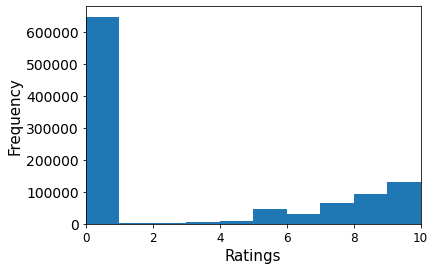

In [10]:
df['rating'].hist(bins=10, grid=False, xlabelsize=12, ylabelsize=14)
plt.xlabel("Ratings", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.xlim([0,10.0])
plt.show()

In [11]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(df['rating'].describe())
r_counts = df['rating'].value_counts()
print(r_counts)

count   1031175.000
mean          2.839
std           3.854
min           0.000
25%           0.000
50%           0.000
75%           7.000
max          10.000
Name: rating, dtype: float64
0     647323
8      91806
10     71227
7      66404
9      60780
5      45355
6      31689
4       7617
3       5118
2       2375
1       1481
Name: rating, dtype: int64


**PreProcessing**

In [12]:
def print_information(df, name):
    df_num_ratings =  df.shape[0]
    df_num_users = len(df['user_id'].unique())
    df_num_books = len(df['isbn'].unique())
    print(f'For {name}:\n\tNumber of unique users: {df_num_users}\n\tNumber of unique books: {df_num_books}\n\tNumber of ratings: {df_num_ratings}')

In [13]:
print_information(df, 'original data frame')

For original data frame:
	Number of unique users: 92107
	Number of unique books: 270170
	Number of ratings: 1031175


In [14]:
#Trim ISBN, as they have an extra space in the end
df['isbn'] = df['isbn'].str.strip()
df['user_id'] = pd.to_numeric(df.user_id, downcast='integer')
#generate artificial Book_ID
df['book_id'] = np.arange(len(df))

Discard all implicit ratings equal to 0

In [15]:
#only taking rating between 1 and 10
df_no_zeros = df.loc[df['rating'] > 0]
print_information(df_no_zeros, 'dataframe only books rated with 1 or higher (i.e. no 0 ratings)')
df_no_zeros['rating'].value_counts().sort_values()

For dataframe only books rated with 1 or higher (i.e. no 0 ratings):
	Number of unique users: 68092
	Number of unique books: 149842
	Number of ratings: 383852


1      1481
2      2375
3      5118
4      7617
6     31689
5     45355
9     60780
7     66404
10    71227
8     91806
Name: rating, dtype: int64

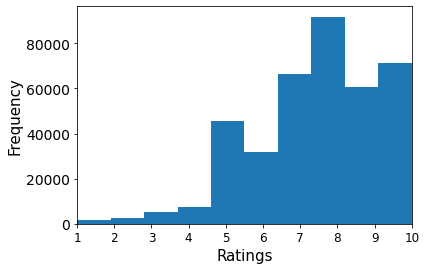

In [16]:
df_no_zeros['rating'].hist(bins=10, grid=False, xlabelsize=12, ylabelsize=14)
plt.xlabel("Ratings", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.xlim([1,10])
plt.show()

Exclude user that rated less than 20 times

In [17]:
#only taking ratings of books where the book was rated at least 20 times
df_10_ratings_least = df_no_zeros.groupby('user_id').filter(lambda df: df.shape[0] > 19)
print_information(df_10_ratings_least, 'dataframe only books rated more than 20 times')

For dataframe only books rated more than 20 times:
	Number of unique users: 3305
	Number of unique books: 108385
	Number of ratings: 217735


DROP unnecessary Colums

In [18]:
columns = ['age', 'year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l', 'city', 'state', 'country']
ratings_f = df_10_ratings_least.drop(columns, axis=1)
ratings_f.head()

,user_id,location,isbn,rating,book_title,book_author,Summary,Language,Category,book_id
3,11676,"n/a, n/a, n/a",0002005018,8,Clara Callan,Richard Bruce Wright,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],3
8,116866,"ottawa, ,",0002005018,9,Clara Callan,Richard Bruce Wright,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],8
13,219008,"halifax, nova scotia, canada",0002005018,7,Clara Callan,Richard Bruce Wright,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],13
14,263325,"fredericton, new brunswick, canada",0002005018,6,Clara Callan,Richard Bruce Wright,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],14
19,35704,"kansas city, missouri, usa",0374157065,6,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,"Describes the great flu epidemic of 1918, an o...",en,['Medical'],19


**Create Train & Test**

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
ratings_f['split'] = np.random.randn(ratings_f.shape[0], 1)
msk = np.random.rand(len(ratings_f)) <= 0.8
train = ratings_f[msk]
test = ratings_f[~msk]

In [21]:
!pip install scikit-surprise
from surprise import Dataset, Reader, SVD, accuracy, NMF
from surprise.model_selection import train_test_split 

reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(train[['user_id','isbn','rating']], reader)
trainset = data.build_full_trainset()


testset = [tuple(x) for x in test[['user_id','isbn','rating']].values]

Functions

In [22]:
def opt_parameters(exp_function, trainset, testset, config=None, param_space_iter=None):
    runs_info = collections.OrderedDict()
    for params in param_space_iter:
        # get key/id
        param_id = ';'.join(['%s=%s' % (key, value) for (key, value) in params.items()])
        print(param_id)
        # run experiment
        exp_info = run_exp(exp_function, trainset, testset, config, config_updates=params)
        # add results to OrderedDict
        runs_info[param_id] = exp_info
    
    return runs_info

In [23]:
def run_exp(exp_function, trainset, testset, config=None, config_updates=None):  
    if config is None:
        config = {}
    else:
        config = config.copy()
    
    if config_updates is not None:
        config.update(config_updates)
        
    return exp_function(config, trainset, testset)

In [24]:
def evaluation(predictions):

    res = {}
    
    res['rmse'] = accuracy.rmse(predictions)
    res['mae'] = accuracy.mae(predictions)
    
    return res

Evaluation Functions

Baseline 

In [25]:
import collections
from sklearn.model_selection import ParameterGrid
from surprise import BaselineOnly

In [26]:
def train_BaselineOnly(config, trainset, testset):
    predictions = BaselineOnly(
        bsl_options = {
            'method': config['method'],
            #'reg': config['reg']
        }).fit(trainset).test(testset)
    
    info = evaluation(predictions)
    
    # return metrics
    return info

In [27]:
config = {
    'method': 'als',
    #'reg': 0.02
}

param_grid = {
    'method': np.array(['als']),
    #'reg': np.array([0.1, 0.02, 0.03])
}

baselineOnly_runs_info = opt_parameters(train_BaselineOnly, config=config, trainset=trainset, testset=testset, param_space_iter=ParameterGrid(param_grid))

method=als
Estimating biases using als...
RMSE: 3.3080
MAE:  2.8964


**SVD**

In [28]:
from sklearn.model_selection import ParameterGrid
import collections

In [29]:
def train_SVD(config, trainset, testset):
    predictions = SVD(
        n_epochs = config['epochs'],
        lr_all = config['learning_rate'],
        reg_all = config['regularization']
    ).fit(trainset).test(testset)
    
    info = evaluation(predictions)
    
    return info

In [30]:
svd_runs_info = opt_parameters(train_SVD, config={
    'epochs': 20,
    'learning_rate': 0.005,
    'regularization': 0.02
}, trainset=trainset, testset=testset, param_space_iter=ParameterGrid(param_grid = {
    'epochs': np.array([20, 35, 50]), # number of iterations of SVD procedure
    'learning_rate': np.array([0.002, 0.005]), # learning rate, default is 0.005
    'regularization': np.array([0.02, 0.05]), # regularization term for all parameters
}))

epochs=20;learning_rate=0.002;regularization=0.02
RMSE: 3.3080
MAE:  2.8963
epochs=20;learning_rate=0.002;regularization=0.05
RMSE: 3.3080
MAE:  2.8962
epochs=20;learning_rate=0.005;regularization=0.02
RMSE: 3.3080
MAE:  2.8965
epochs=20;learning_rate=0.005;regularization=0.05
RMSE: 3.3079
MAE:  2.8963
epochs=35;learning_rate=0.002;regularization=0.02
RMSE: 3.3079
MAE:  2.8964
epochs=35;learning_rate=0.002;regularization=0.05
RMSE: 3.3080
MAE:  2.8963
epochs=35;learning_rate=0.005;regularization=0.02
RMSE: 3.3081
MAE:  2.8969
epochs=35;learning_rate=0.005;regularization=0.05
RMSE: 3.3080
MAE:  2.8966
epochs=50;learning_rate=0.002;regularization=0.02
RMSE: 3.3080
MAE:  2.8965
epochs=50;learning_rate=0.002;regularization=0.05
RMSE: 3.3080
MAE:  2.8964
epochs=50;learning_rate=0.005;regularization=0.02
RMSE: 3.3083
MAE:  2.8971
epochs=50;learning_rate=0.005;regularization=0.05
RMSE: 3.3081
MAE:  2.8967


**NMF**

In [31]:
from sklearn.model_selection import ParameterGrid
import collections

In [32]:
def train_NMF(config, trainset, testset):
    predictions = SVD(
        n_epochs = config['epochs'],
        lr_all = config['learning_rate'],
        reg_all = config['regularization']
    ).fit(trainset).test(testset)
    
    info = evaluation(predictions)
    
    # return metrics
    return info

In [33]:
svd_runs_info = opt_parameters(train_NMF, config={
    'n_factors': 5,
    'epochs': 20,
    'learning_rate': 0.005,
    'regularization': 0.02
}, trainset=trainset, testset=testset, param_space_iter=ParameterGrid(param_grid = {
    'n_factors': np.array([5, 10]),
    'epochs': np.array([20, 35, 50]), # number of iterations of NMF procedure
    'learning_rate': np.array([0.002, 0.005]), # learning rate, default is 0.005
    'regularization': np.array([0.02, 0.05]), # regularization term for all parameters
}))

epochs=20;learning_rate=0.002;n_factors=5;regularization=0.02
RMSE: 3.3079
MAE:  2.8963
epochs=20;learning_rate=0.002;n_factors=5;regularization=0.05
RMSE: 3.3080
MAE:  2.8962
epochs=20;learning_rate=0.002;n_factors=10;regularization=0.02
RMSE: 3.3080
MAE:  2.8963
epochs=20;learning_rate=0.002;n_factors=10;regularization=0.05
RMSE: 3.3080
MAE:  2.8962
epochs=20;learning_rate=0.005;n_factors=5;regularization=0.02
RMSE: 3.3080
MAE:  2.8965
epochs=20;learning_rate=0.005;n_factors=5;regularization=0.05
RMSE: 3.3079
MAE:  2.8964
epochs=20;learning_rate=0.005;n_factors=10;regularization=0.02
RMSE: 3.3080
MAE:  2.8965
epochs=20;learning_rate=0.005;n_factors=10;regularization=0.05
RMSE: 3.3080
MAE:  2.8964
epochs=35;learning_rate=0.002;n_factors=5;regularization=0.02
RMSE: 3.3079
MAE:  2.8964
epochs=35;learning_rate=0.002;n_factors=5;regularization=0.05
RMSE: 3.3079
MAE:  2.8963
epochs=35;learning_rate=0.002;n_factors=10;regularization=0.02
RMSE: 3.3080
MAE:  2.8964
epochs=35;learning_rate=0.0

**KNN**

In [34]:
from surprise import KNNBasic
import pandas as pd

def train_KNNBasic(config, trainset, testset):
    predictions = KNNBasic(
        k = config['k'],
        sim_options = {
            'name': config['sim_name'],
            'min_support': config['min_support'],
            'user_based': config['user_based']
        }
    ).fit(trainset).test(testset)
    
    info = evaluation(predictions)
    #predictions = pd.DataFrame(predictions)
    print(predictions[0:1000])
    predictions.to_csv("/content/drive/My Drive/WebMining2/predicitons_user.csv")
    # return metrics
    return info

In [35]:
from surprise import KNNWithMeans
def train_KNNWithMeans(config, trainset, testset):
    predictions = KNNWithMeans(
        k = config['k'],
        sim_options = {
            'name': config['sim_name'],
            'min_support': config['min_support'],
            'user_based': config['user_based']
        }
    ).fit(trainset).test(testset)
    
    info = evaluation(predictions)
    
    # return metrics
    return info

**Item Based CF**

KNN Baseline

In [ ]:
config = {
    'k': 5,
    'sim_name': 'cosine',
    'min_support': 1,
    'user_based': False
}
param_grid = {
    'k': np.array([5, 10, 20]),
    'sim_name': np.array(['cosine', 'msd', 'pearson', 'pearson_baseline']),
    'min_support': np.array([1, 3, 5])
}

ib_knnbasic_runs_info = opt_parameters(train_KNNBasic, config=config, trainset=trainset, testset=testset, param_space_iter=ParameterGrid(param_grid), )

k=5;min_support=1;sim_name=cosine
Computing the cosine similarity matrix...


**KNN with means**

In [ ]:
config = {
    'k': 40,
    'sim_name': 'cosine',
    'min_support': 1,
    'user_based': False
}

param_grid = {
    'k': np.array([30, 40, 50, 60]),
    'sim_name': np.array(['cosine', 'msd', 'pearson_baseline']),
    'min_support': np.array([1, 3, 5])
}
ib_knnmeans_runs_info = opt_parameters(train_KNNWithMeans, config=config, trainset=trainset, testset=testset, param_space_iter=ParameterGrid(param_grid))

**User-Based CF**

KNN Baseline

In [ ]:
config = {
    'k': 5,
    'sim_name': 'cosine',
    'min_support': 1,
    'user_based': True
}

param_grid = {
    'k': np.array([5, 10, 20]),
    'sim_name': np.array(['cosine', 'msd', 'pearson', 'pearson_baseline']),
    'min_support': np.array([1, 3, 5])
}

ib_knnbasic_runs_info = opt_parameters(train_KNNBasic, config=config, trainset=trainset, testset=testset, param_space_iter=ParameterGrid(param_grid))

KNN with means

In [ ]:
config = {
    'k': 40,
    'sim_name': 'cosine',
    'min_support': 1,
    'user_based': True
}

param_grid = {
    'k': np.array([30, 40, 50, 60]),
    'sim_name': np.array(['cosine', 'msd', 'pearson_baseline']),
    'min_support': np.array([1, 3, 5])
}

ib_knnmeans_runs_info = opt_parameters(train_KNNWithMeans, config=config, trainset=trainset, testset=testset, param_space_iter=ParameterGrid(param_grid))